<a href="https://colab.research.google.com/github/5237-mests/Customer_Experience_Analytics_for_Fintech_Apps/blob/task-2/notebooks/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import dependencies
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#for downloading data
import kagglehub

#sentiment analysis
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

#keyword Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#visuals
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

In [4]:
# Load cbe review data
cbe_df = pd.read_csv('cleaned_cbe_bank_reviews.csv')


In [6]:
cbe_df.head()

,review,rating,date,bank,source
0,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play
1,I cannot send to cbebirr app. through this app.,3,2025-06-05,Commercial Bank of Ethiopia,Google Play
2,good,4,2025-06-05,Commercial Bank of Ethiopia,Google Play
3,not functional,1,2025-06-05,Commercial Bank of Ethiopia,Google Play
4,everytime you uninstall the app you have to re...,1,2025-06-04,Commercial Bank of Ethiopia,Google Play


### Preprocessing the Data

Steps:


* Clean text: Remove punctuation, special characters, convert to lowercase.
*  Tokenize: Split text into words.
*  Remove stop words: Eliminate common words (e.g., "the," "and").
*  Lemmatize: Reduce words to base form (e.g., "running" → "run").

In [8]:
# Preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
cbe_df['processed_review'] = cbe_df['review'].apply(preprocess_text)

In [9]:
cbe_df.head()

,review,rating,date,bank,source,processed_review
0,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play,app proactive good connection
1,I cannot send to cbebirr app. through this app.,3,2025-06-05,Commercial Bank of Ethiopia,Google Play,send cbebirr app app
2,good,4,2025-06-05,Commercial Bank of Ethiopia,Google Play,good
3,not functional,1,2025-06-05,Commercial Bank of Ethiopia,Google Play,functional
4,everytime you uninstall the app you have to re...,1,2025-06-04,Commercial Bank of Ethiopia,Google Play,everytime uninstall app reach physically oldy ...


### Sentiment Analysis with TextBlob

Description: TextBlob provides a straightforward way to classify sentiments based on polarity scores.

In [10]:
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis
cbe_df['sentiment'] = cbe_df['processed_review'].apply(get_sentiment)

# Display sentiment distribution
print(cbe_df['sentiment'].value_counts())

sentiment
positive    424
neutral     255
negative     62
Name: count, dtype: int64


In [11]:
cbe_df.head()

,review,rating,date,bank,source,processed_review,sentiment
0,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play,app proactive good connection,positive
1,I cannot send to cbebirr app. through this app.,3,2025-06-05,Commercial Bank of Ethiopia,Google Play,send cbebirr app app,neutral
2,good,4,2025-06-05,Commercial Bank of Ethiopia,Google Play,good,positive
3,not functional,1,2025-06-05,Commercial Bank of Ethiopia,Google Play,functional,neutral
4,everytime you uninstall the app you have to re...,1,2025-06-04,Commercial Bank of Ethiopia,Google Play,everytime uninstall app reach physically oldy ...,positive


### Sentiment Analysis with VADER
Description: VADER is tailored for short texts like reviews, accounting for sentiment intensity and informal language.

In [13]:
# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] > 0.05:
        return 'positive'
    elif scores['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply VADER sentiment analysis
cbe_df['vader_sentiment'] = cbe_df['review'].apply(get_vader_sentiment)

# Display sentiment distribution
print(cbe_df['vader_sentiment'].value_counts())

vader_sentiment
positive    421
neutral     228
negative     92
Name: count, dtype: int64


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
cbe_df.head()

,review,rating,date,bank,source,processed_review,sentiment,vader_sentiment
0,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play,app proactive good connection,positive,positive
1,I cannot send to cbebirr app. through this app.,3,2025-06-05,Commercial Bank of Ethiopia,Google Play,send cbebirr app app,neutral,neutral
2,good,4,2025-06-05,Commercial Bank of Ethiopia,Google Play,good,positive,positive
3,not functional,1,2025-06-05,Commercial Bank of Ethiopia,Google Play,functional,neutral,neutral
4,everytime you uninstall the app you have to re...,1,2025-06-04,Commercial Bank of Ethiopia,Google Play,everytime uninstall app reach physically oldy ...,positive,positive


# Advanced Sentiment Analysis with Machine Learning

Description: Machine learning models like Naive Bayes improve accuracy by training on labeled data.

**Steps**:
* Use star ratings as labels (e.g., 4-5 stars = positive, 1-2 stars = negative).
* Extract features using TF-IDF.
* Train and evaluate a classifier.

In [15]:
# Create labels based on ratings
cbe_df['label'] = cbe_df['rating'].apply(lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral'))

# Vectorize text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cbe_df['processed_review'])
y = cbe_df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.7785234899328859


Keyword Extraction with TF-IDF





Description: TF-IDF identifies words that are important in specific reviews relative to the entire dataset.

In [16]:
# Vectorize the dataset
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(cbe_df['processed_review'])

# Get top keywords
keywords = vectorizer.get_feature_names_out()
print("Top Keywords:", keywords)

Top Keywords: ['access' 'account' 'add' 'amazing' 'app' 'application' 'apps' 'back'
 'bad' 'bank' 'banking' 'best' 'better' 'birr' 'bug' 'ca' 'cbe'
 'commercial' 'could' 'crash' 'crashing' 'customer' 'day' 'developer'
 'easy' 'ethiopia' 'even' 'ever' 'every' 'excellent' 'experience'
 'fantastic' 'fast' 'feature' 'fix' 'get' 'give' 'go' 'good' 'great'
 'happy' 'history' 'issue' 'keep' 'like' 'look' 'love' 'made' 'make'
 'many' 'mobile' 'mode' 'money' 'much' 'need' 'network' 'new' 'nice' 'one'
 'open' 'option' 'payment' 'please' 'problem' 'really' 'reason' 'reliable'
 'save' 'say' 'screen' 'screenshot' 'security' 'send' 'service' 'simple'
 'sometimes' 'system' 'take' 'thank' 'thanks' 'thing' 'time' 'transaction'
 'transfer' 'try' 'turn' 'update' 'use' 'used' 'useful' 'user' 'using'
 'without' 'work' 'working' 'would' 'wow' 'በጣም' 'ነው' 'ግን']


# Combining Sentiment Analysis and Keyword Extraction

Description: Analyze keywords in positive vs. negative reviews to understand user preferences and issues.

In [17]:
# Filter positive and negative reviews
positive_reviews = cbe_df[cbe_df['sentiment'] == 'positive']['processed_review']
negative_reviews = cbe_df[cbe_df['sentiment'] == 'negative']['processed_review']

# Extract keywords from positive reviews
vectorizer_pos = TfidfVectorizer(max_features=10)
X_pos = vectorizer_pos.fit_transform(positive_reviews)
print("Top Keywords in Positive Reviews:", vectorizer_pos.get_feature_names_out())

# Extract keywords from negative reviews
vectorizer_neg = TfidfVectorizer(max_features=10)
X_neg = vectorizer_neg.fit_transform(negative_reviews)
print("Top Keywords in Negative Reviews:", vectorizer_neg.get_feature_names_out())

Top Keywords in Positive Reviews: ['app' 'application' 'bank' 'best' 'cbe' 'easy' 'good' 'nice' 'update'
 'use']
Top Keywords in Negative Reviews: ['app' 'bank' 'banking' 'developer' 'fix' 'screenshot' 'time' 'update'
 'use' 'worst']


# Visualizing the Results

**Visualizations**:
* Bar Chart: Show the distribution of positive, negative, and neutral sentiments.
* Word Cloud: Visualize frequent keywords in positive and negative reviews.

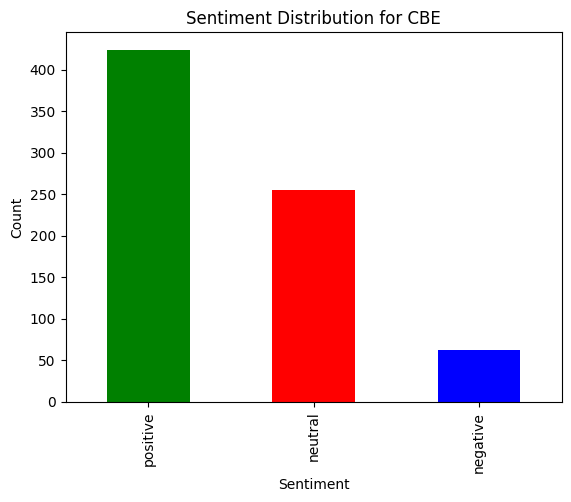

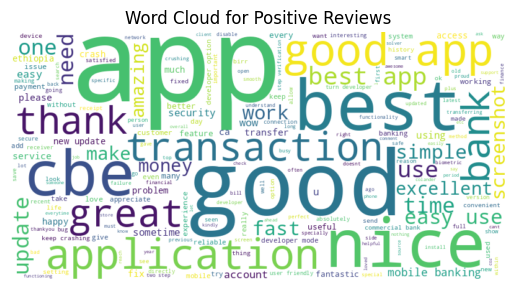

In [19]:
# Sentiment distribution
cbe_df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution for CBE')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Word cloud for positive reviews
positive_text = ' '.join(positive_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

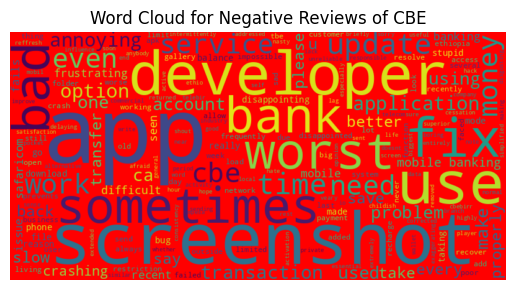

In [21]:
negative_text = ' '.join(negative_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='red').generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews of CBE')
plt.show()